<a href="https://colab.research.google.com/github/abhigoogol/Autoencoders-using-Pytorch/blob/master/05_Denoising_Autoencoder_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function

import torchvision
from torchvision import transforms

from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import random
from tqdm import tqdm_notebook

plt.style.use('default')

In [0]:
transform = transforms.Compose([transforms.ToTensor()])
bs = 1000
traindataset = torchvision.datasets.MNIST(root='./MNIST', download=True, train=True, transform=transform)
trainloader = DataLoader(traindataset, shuffle=True, batch_size=bs, num_workers=4)

testdataset = torchvision.datasets.MNIST(root='./MNIST', download=True, train=False, transform=transform)
testloader = DataLoader(testdataset, shuffle=False, batch_size=bs, num_workers=4)

In [9]:
GPU = 0
if torch.cuda.is_available():
  print('GPU available!')
  GPU = 1

GPU available!


In [0]:
def imshow(img, title=None):
#     img = img / 2 + 0.5     # unnormalize
  npimg = img.cpu().detach().numpy()
  plt.title(title)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# # get some random training images
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# print(images.shape, labels.shape)

# # show images
# imshow(torchvision.utils.make_grid(images))
# imshow(torchvision.utils.make_grid(labels))

In [0]:
class L1Penality(torch.autograd.Function):
  
  """
  In the forward pass we receive a Tensor containing the input and return
  a Tensor containing the output. ctx is a context object that can be used
  to stash information for backward computation. You can cache arbitrary
  objects for use in the backward pass using the ctx.save_for_backward method.
  """
  @staticmethod
  def forward(ctx, input, l1weight):
    ctx.save_for_backward(input)
    ctx.l1weight = l1weight
    return input
  
  """
  In the backward pass we receive a Tensor containing the gradient of the loss
  with respect to the output, and we need to compute the gradient of the loss
  with respect to the input.
  """
  @staticmethod
  def backward(ctx, grad_output):
    input, = ctx.saved_tensors
    grad_input = input.clone().sign().mul(ctx.l1weight)
    grad_input += grad_output
    return grad_input, None

In [12]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(nn.Linear(28*28, 400),
                           nn.Tanh())
    self.decoder = nn.Sequential(nn.Linear(400, 28*28),
                           nn.Sigmoid())
  
  def forward(self, x):
    x = self.encoder(x)
    x = L1Penality.apply(x, 0.1)  # 10% of the weights are supposed to be zero
    x = self.decoder(x)
    return x
    
net = Autoencoder()
print(net)

if GPU:
  net = net.cuda()

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


# Optimization Technique

In [0]:
lr = 1e-3
noise_mean = 0.1
noise_std = 0.2
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

# Train Autoencoder

In [15]:
epochs = 300
for epoch in tqdm_notebook(range(epochs)):
  runningloss = 0
  
  for images, labels in trainloader:
    if GPU:
      images, labels = Variable(images.view(-1, 28*28)).cuda(), Variable(labels).cuda()
      noise = torch.tensor(torch.from_numpy(np.random.normal(noise_mean, noise_std, images.shape)), dtype=torch.float).cuda()
      noise_image = Variable(torch.clamp(images+noise, 0, 1)).cuda()
    else:
      noise = Variable(torch.tensor(np.random.normal(noise_mean, noise_std, images.view(-1, 28*28).shape)))
      noise_image = Variable(torch.clamp(images+noise, 0, 1))
    
    optimizer.zero_grad()
    outputs = net(noise_image) # forward 
    loss = criterion(outputs, images) # calculate loss
    loss.backward() #  backpropagate the loss
    optimizer.step()
    
    runningloss += loss.item()
   
  print('Epoch: {}/{} \t Mean Square Error Loss: {}'.format(epoch+1, epochs, runningloss/len(trainloader)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Epoch: 1/300 	 Mean Square Error Loss: 0.22600931997100512
Epoch: 2/300 	 Mean Square Error Loss: 0.2153520608941714
Epoch: 3/300 	 Mean Square Error Loss: 0.2056486961742242
Epoch: 4/300 	 Mean Square Error Loss: 0.19645752608776093
Epoch: 5/300 	 Mean Square Error Loss: 0.18789292126893997
Epoch: 6/300 	 Mean Square Error Loss: 0.17987878595789272
Epoch: 7/300 	 Mean Square Error Loss: 0.17231318379441898
Epoch: 8/300 	 Mean Square Error Loss: 0.16527568995952607
Epoch: 9/300 	 Mean Square Error Loss: 0.15869163920482
Epoch: 10/300 	 Mean Square Error Loss: 0.15256677294770876
Epoch: 11/300 	 Mean Square Error Loss: 0.14691365684072177
Epoch: 12/300 	 Mean Square Error Loss: 0.14169392362236977
Epoch: 13/300 	 Mean Square Error Loss: 0.13682461952169736
Epoch: 14/300 	 Mean Square Error Loss: 0.13231847087542217
Epoch: 15/300 	 Mean Square Error Loss: 0.12823794186115264
Epoch: 16/300 	 Mean Square Error Loss: 0.12433460106452306
Epoch: 17/300 	 Mean Square Error Loss: 0.120781647165

# Autoencoder Performance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


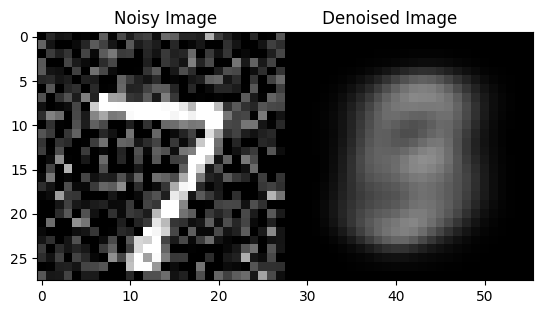

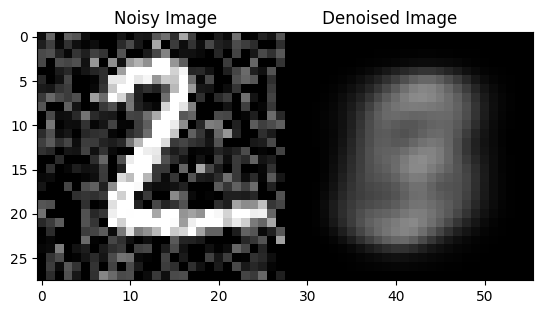

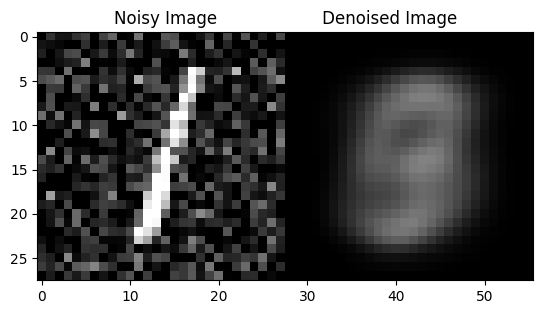

In [16]:
images, labels = next(iter(testloader))
images, labels = Variable(images.view(-1, 28*28)).cuda(), Variable(labels).cuda()
noise = torch.tensor(torch.from_numpy(np.random.normal(noise_mean, noise_std, images.shape)), dtype=torch.float).cuda()
noise_image = Variable(torch.clamp(images+noise, 0, 1)).cuda()
output_test = net(noise_image)

for i in range(3):
  imshow(torchvision.utils.make_grid(torch.cat((noise_image[i].view(28, 28), torch.clamp(output_test[i].view(28, 28), 0, 1)), dim=1)), title='Noisy Image                    Denoised Image')

# Encoder Weight Visualization

In [0]:
trained_weightsE = copy.deepcopy(net.encoder[0].weight.data)
d_weightsE = init_weightsE - trained_weightsE

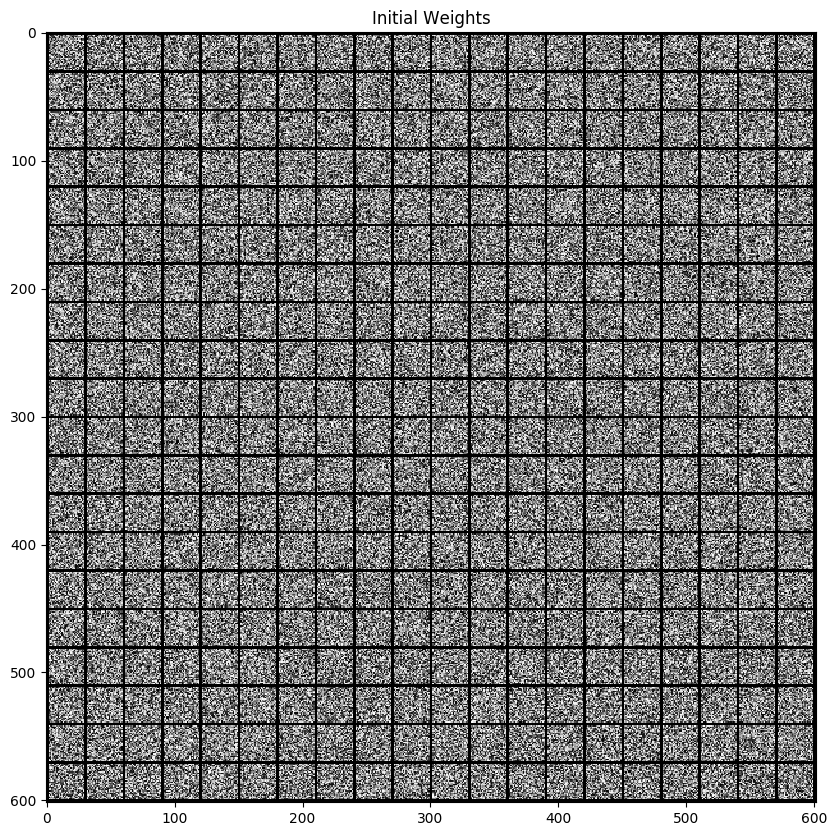

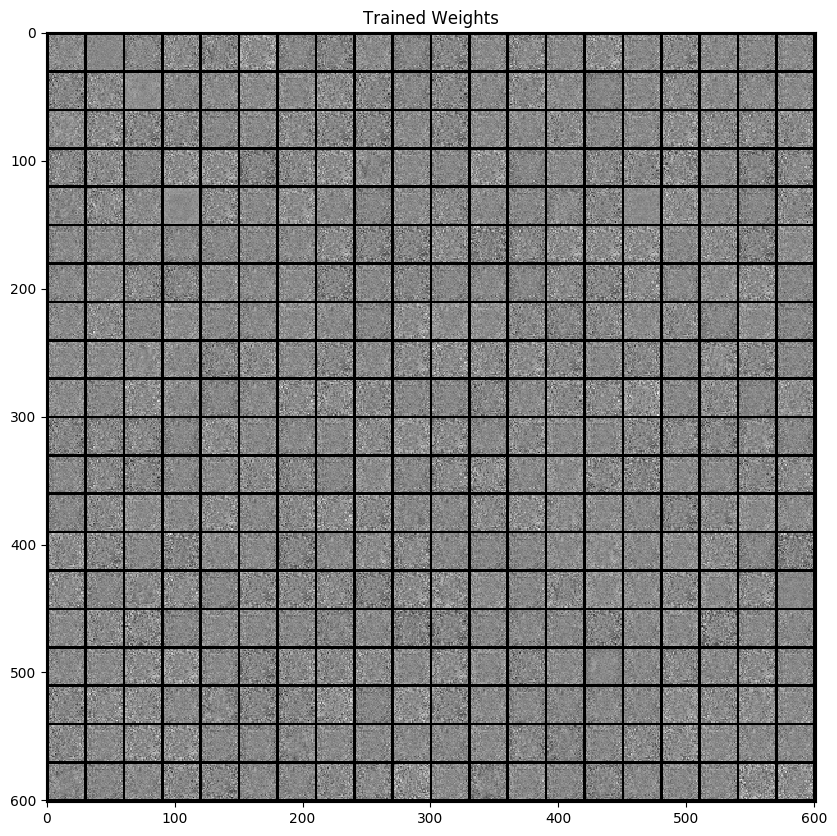

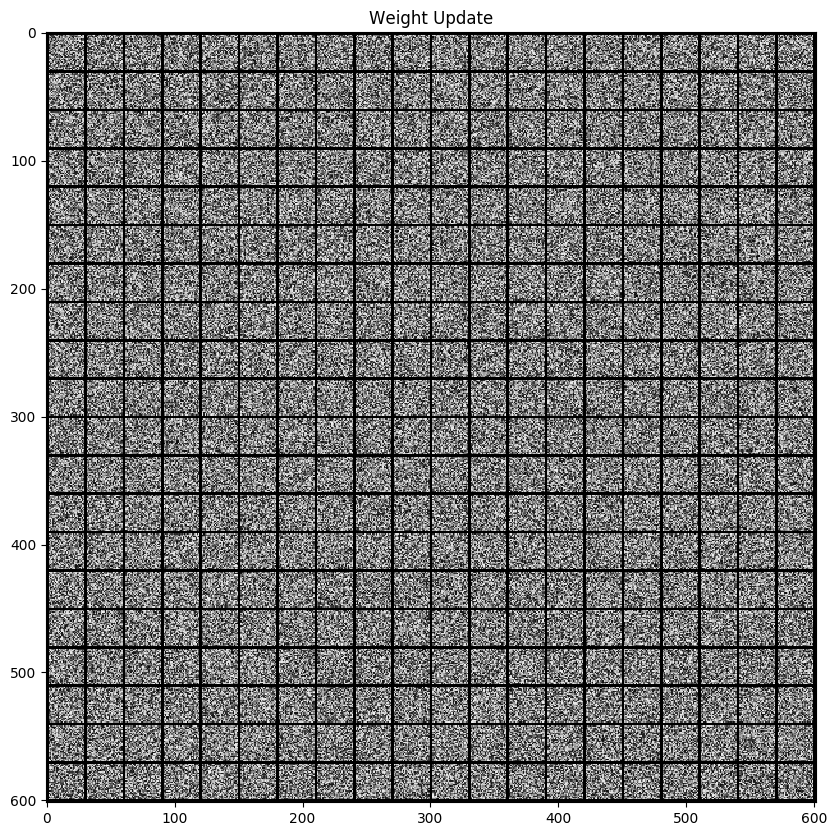

In [18]:
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(init_weightsE.view(400, 1, 28, 28), nrow=20, normalize=True), 'Initial Weights')
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(trained_weightsE.view(400, 1, 28, 28), nrow=20, normalize=True), 'Trained Weights')
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(d_weightsE.view(400, 1, 28, 28), nrow=20, normalize=True), 'Weight Update')

# Decoder Weight Visualization

In [0]:
trained_weightsD = copy.deepcopy(net.decoder[0].weight.data)
d_weightsD = init_weightsD - trained_weightsD

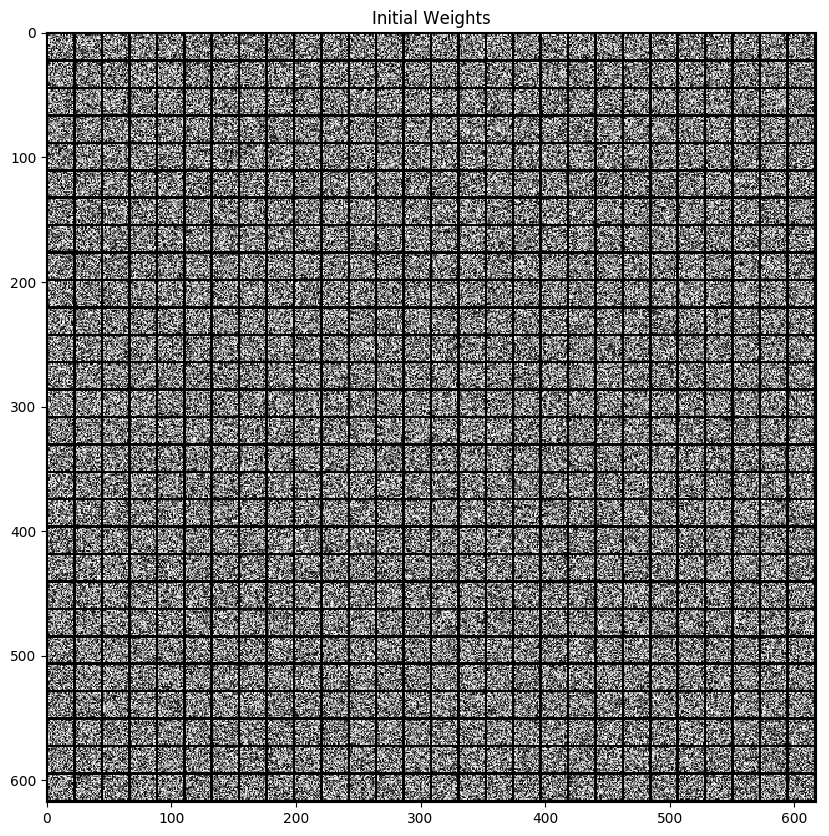

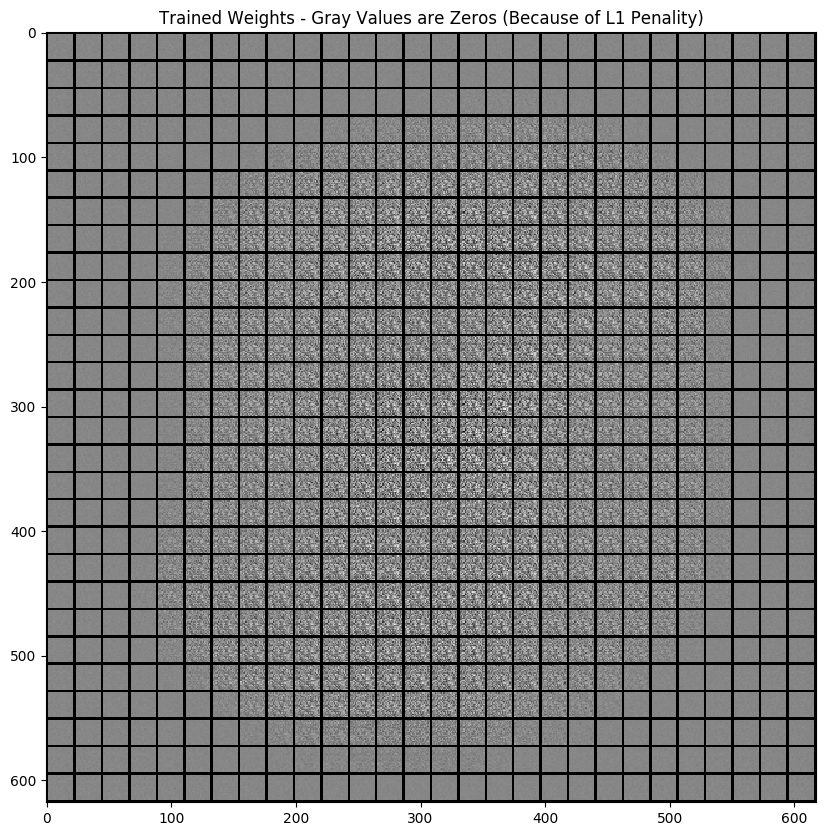

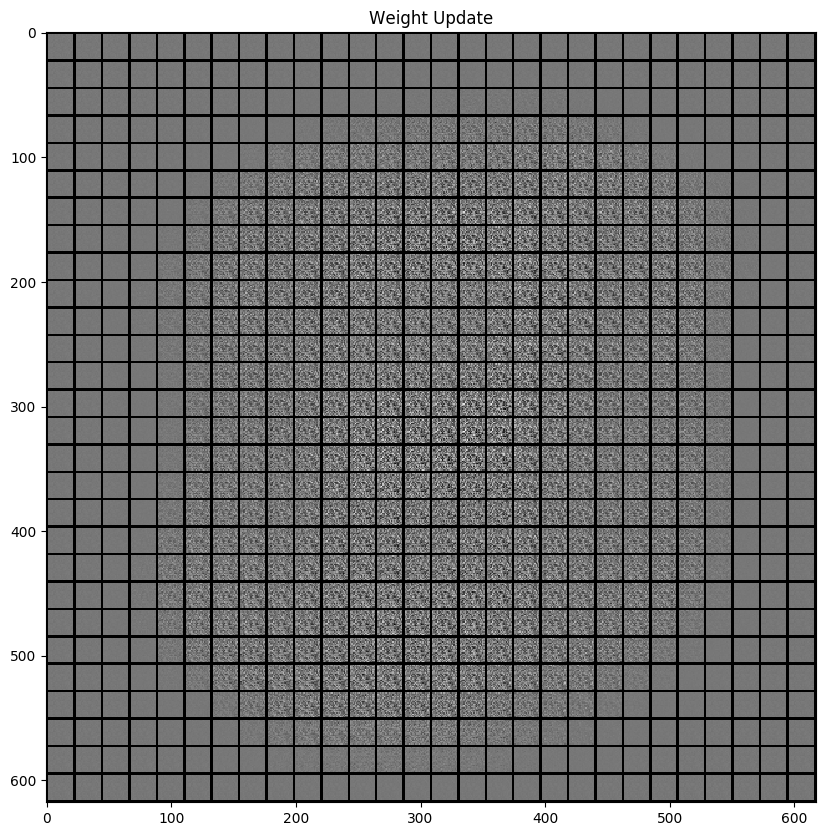

In [20]:
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(init_weightsD.view(784, 1, 20, 20), nrow=28, normalize=True), 'Initial Weights')
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(trained_weightsD.view(784, 1, 20, 20), nrow=28, normalize=True), 'Trained Weights - Gray Values are Zeros (Because of L1 Penality)')
plt.figure(figsize=(10, 10))
imshow(torchvision.utils.make_grid(d_weightsD.view(784, 1, 20, 20), nrow=28, normalize=True), 'Weight Update')

# Training as Classifier

In [21]:
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
net.add_module('classifier', nn.Sequential(nn.Linear(400, 10),
                                          nn.LogSoftmax(dim=1)))

print(net)
if GPU:
  net = net.cuda()

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=10, bias=True)
    (1): LogSoftmax()
  )
)


In [0]:
criterion = nn.NLLLoss()
lr = 0.01

In [23]:
epochs = 50

for epoch in tqdm_notebook(range(epochs)):
  runningloss = 0
  
  for images, labels in trainloader:
    net.train()
    if GPU:
      images, labels = Variable(images.view(-1, 28*28)).cuda(), Variable(labels).cuda()
    
    net.zero_grad()  # zeroes the gradient buffers of all parameters
    outputs = net(images) # forward 
    loss = criterion(outputs, labels) # calculate loss
    loss.backward() #  backpropagate the loss
    for f in net.parameters():
      f.data.sub_(f.grad.data * lr) # weight = weight - learning_rate * gradient (Update Weights)
    runningloss += loss.item()
    
  else:
    net.eval()
    correct = 0
    with torch.no_grad():
      for data in testloader:
        inputs, labels = data
        if GPU:
          images, labels = Variable(inputs.view(-1, 28*28)).cuda(), labels.cuda()
        else:
          images, labels = Variable(inputs.view(-1, 28*28)), labels
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        correct += torch.sum(predicted==labels).item()
    accuracy = correct / len(testloader.dataset)
  print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch+1, epochs, runningloss/len(testloader), accuracy))
print('Finished Training')


At Iteration : 1 / 50  ;  Train Error : 13.194449 ;Test Accuracy : 0.718200
At Iteration : 2 / 50  ;  Train Error : 11.944851 ;Test Accuracy : 0.745700
At Iteration : 3 / 50  ;  Train Error : 10.637002 ;Test Accuracy : 0.756300
At Iteration : 4 / 50  ;  Train Error : 9.317109 ;Test Accuracy : 0.770500
At Iteration : 5 / 50  ;  Train Error : 8.115787 ;Test Accuracy : 0.787400
At Iteration : 6 / 50  ;  Train Error : 7.115307 ;Test Accuracy : 0.804600
At Iteration : 7 / 50  ;  Train Error : 6.320065 ;Test Accuracy : 0.816900
At Iteration : 8 / 50  ;  Train Error : 5.696624 ;Test Accuracy : 0.827300
At Iteration : 9 / 50  ;  Train Error : 5.205773 ;Test Accuracy : 0.835900
At Iteration : 10 / 50  ;  Train Error : 4.814381 ;Test Accuracy : 0.843100
At Iteration : 11 / 50  ;  Train Error : 4.497398 ;Test Accuracy : 0.850300
At Iteration : 12 / 50  ;  Train Error : 4.236376 ;Test Accuracy : 0.856000
At Iteration : 13 / 50  ;  Train Error : 4.018337 ;Test Accuracy : 0.860900
At Iteration : 14 

# Testing Performance

In [24]:
classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

class_correct = np.array([0.] * 10)
class_total = np.array([0.] * 10)
for data in testloader:
    images, labels = data
    if GPU:
        outputs = net(Variable(images.view(-1, 28*28).cuda()))
        _, predicted = torch.max(outputs.cpu(), 1)
    else:
        outputs = net(Variable(images.view(-1, 28*28)))
        _, predicted = torch.max(outputs, 1)
    c = (predicted == labels)
    for i in range(bs):
        label = labels[i].item()
        class_correct[label] += c[i].item()
        class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100 * class_correct[i] / float(class_total[i])))

Accuracy of  zero : 97.653061 %
Accuracy of   one : 97.268722 %
Accuracy of   two : 86.143411 %
Accuracy of three : 88.910891 %
Accuracy of  four : 91.955193 %
Accuracy of  five : 82.511211 %
Accuracy of   six : 92.588727 %
Accuracy of seven : 89.980545 %
Accuracy of eight : 85.831622 %
Accuracy of  nine : 87.413280 %
